In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:20,.4f}'.format

Do for each year

In [41]:
df1 = pd.read_feather('./data/2018taxi_weather.feather').drop('index', axis=1)

display(df1.columns)
display(df1.head())

Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type',
       'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'total_amount', 'trip_duration', 'dow', 'hour', 'tmpc', 'heavy_snow',
       'snow'],
      dtype='object')

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,trip_duration,dow,hour,tmpc,heavy_snow,snow
0,1,1,0.5000,1.0000,N,41,24,2,4.5000,0.5000,0.5000,0.0000,0.0000,5.8000,3,0,0,nan,nan,nan
1,1,1,2.7000,1.0000,N,239,140,2,14.0000,0.5000,0.5000,0.0000,0.0000,15.3000,18,0,0,-11.0000,0.0000,0.0000
2,1,2,0.8000,1.0000,N,262,141,1,6.0000,0.5000,0.5000,1.0000,0.0000,8.3000,5,0,0,nan,nan,nan
3,1,1,10.2000,1.0000,N,140,257,2,33.5000,0.5000,0.5000,0.0000,0.0000,34.8000,32,0,0,nan,nan,nan
4,1,2,2.5000,1.0000,N,246,239,1,12.5000,0.5000,0.5000,2.7500,0.0000,16.5500,17,0,0,nan,nan,nan


In [3]:
df1.skew()

VendorID                       -0.1930
passenger_count                 2.3035
trip_distance                   3.5926
RatecodeID                     14.2416
PULocationID                   -0.2118
DOLocationID                   -0.2434
payment_type                    1.0696
fare_amount                 3,013.8488
extra                           7.8190
mta_tax                       -29.9724
tip_amount                      9.1898
tolls_amount                  189.2119
total_amount                2,996.9635
trip_duration                  22.8489
dow                             0.0143
hour                           -1.1464
tmpc                            0.1931
heavy_snow                     10.8574
snow                           10.9922
dtype: float64

In [4]:
df1[['fare_amount', 'tolls_amount', 'total_amount']].describe()

,fare_amount,tolls_amount,total_amount
count,"27,140,443.0000","27,140,443.0000","27,140,443.0000"
mean,12.3352,0.2144,15.8674
std,112.8906,1.5514,113.1017
min,0.1000,-5.5400,1.4000
25%,6.5000,0.0000,8.8000
50%,9.5000,0.0000,12.3000
75%,14.5000,0.0000,18.1700
max,"391,911.7800","1,018.9500","391,913.5800"


Wow... these are insanely skewed

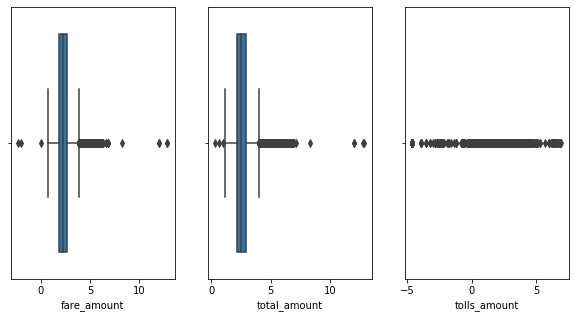

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
sns.boxplot(np.log(df1.fare_amount), ax=ax[0])
sns.boxplot(np.log(df1.total_amount), ax=ax[1])
sns.boxplot(np.log(df1.tolls_amount), ax=ax[2])

Since fare_amount seems to have unrealistic costs, we should follow the data dictionary.
- `RatecodeID` 5 and 6 will be dropped
- Any trip that does not have `payment_type` 1 or 2 will be dropped
- Trips over $500 will also be dropped since it is an extreme outlier, regardless of distance

According to the taxi fares and NYC toll rates, even if a passenger went by every tollway **and** payed for the return toll fee, the maximum cost would only reach `374.94`. As a safe measure, we can assume any toll amount greater than this is incorrect.

Furthermore, there is a minimum `2.50` hailing fee. So any instance with a `total_amount` less than this fee is incorrect.

In [42]:
to_drop = df1.loc[df1['RatecodeID'] == 5].index

to_drop = to_drop.append(df1.loc[df1['RatecodeID'] == 6].index)
to_drop = to_drop.append(df1.loc[df1['payment_type'] == 3].index)
to_drop = to_drop.append(df1.loc[df1['payment_type'] == 4].index)
to_drop = to_drop.append(df1.loc[df1['payment_type'] == 5].index)
to_drop = to_drop.append(df1.loc[df1['payment_type'] == 6].index)
to_drop = to_drop.append(df1.loc[df1['fare_amount'] >= 500].index)
to_drop = to_drop.append(df1.loc[df1['tolls_amount'] > 374.94].index)
to_drop = to_drop.append(df1.loc[df1['total_amount'] <= 2.5].index)

In [43]:
df1.drop(index=to_drop, axis=1, inplace=True)

In [8]:
df1.skew()

VendorID                       -0.2046
passenger_count                 2.2989
trip_distance                   3.4431
RatecodeID                     14.2830
PULocationID                   -0.2120
DOLocationID                   -0.2436
payment_type                    0.8531
fare_amount                     2.8100
extra                           6.7801
mta_tax                       -30.1516
tip_amount                      8.9565
tolls_amount                    9.3585
total_amount                    3.0786
trip_duration                  22.8046
dow                             0.0149
hour                           -1.1499
tmpc                            0.1931
heavy_snow                     10.8572
snow                           10.9920
dtype: float64

In [9]:
df1[['fare_amount', 'tolls_amount', 'total_amount']].describe()

,fare_amount,tolls_amount,total_amount
count,"26,999,747.0000","26,999,747.0000","26,999,747.0000"
mean,12.2851,0.2123,15.8246
std,9.2810,1.1832,11.5310
min,2.0000,-5.5400,3.3000
25%,6.5000,0.0000,8.8000
50%,9.5000,0.0000,12.3000
75%,14.5000,0.0000,18.1700
max,465.5000,300.0000,552.5700


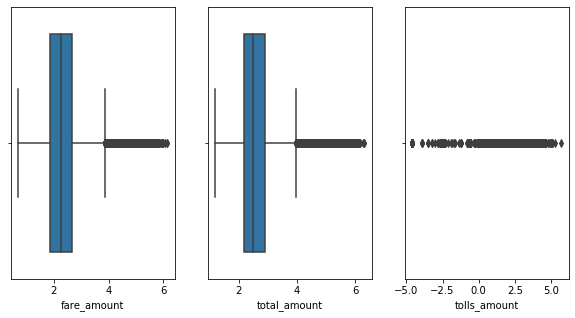

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
sns.boxplot(np.log(df1.fare_amount), ax=ax[0])
sns.boxplot(np.log(df1.total_amount), ax=ax[1])
sns.boxplot(np.log(df1.tolls_amount), ax=ax[2])

The data now looks much more reasonable to work with
- Tolls are still positive skewed, but that's okay since some trips may go through *numerous* tollways

We can also drop the columns that have no use:
- `VendorID` is just the data provider and is used for reporting
- `passenger_count` may seem useful, do not affect the `fare_rate` made (and hence the profitability). 
    - This is because we already removed any `RatecodeID` of 6 which were group rides
- `RatecodeID` has been conditioned to standard trips, so we can now work with the data conditioned on this
- `store_and_fwd_flag` only indicates whether or not the information was stored in memory of the taxi, rather than being sent during transaction
- `payment_type` like `RatecodeID`, has been conditioned to cash or card payments. So, we can also work with the data conditioned on this
- `mta_tax` and `improvement_surcharge` are a constant surcharge to all trips

In [44]:
df1.drop(['VendorID','passenger_count','RatecodeID','store_and_fwd_flag','payment_type','mta_tax'],axis=1,inplace=True)

df1.head()

,trip_distance,PULocationID,DOLocationID,fare_amount,extra,tip_amount,tolls_amount,total_amount,trip_duration,dow,hour,tmpc,heavy_snow,snow
0,0.5000,41,24,4.5000,0.5000,0.0000,0.0000,5.8000,3,0,0,nan,nan,nan
1,2.7000,239,140,14.0000,0.5000,0.0000,0.0000,15.3000,18,0,0,-11.0000,0.0000,0.0000
2,0.8000,262,141,6.0000,0.5000,1.0000,0.0000,8.3000,5,0,0,nan,nan,nan
3,10.2000,140,257,33.5000,0.5000,0.0000,0.0000,34.8000,32,0,0,nan,nan,nan
4,2.5000,246,239,12.5000,0.5000,2.7500,0.0000,16.5500,17,0,0,nan,nan,nan


In [12]:
df1.corr()

,trip_distance,PULocationID,DOLocationID,fare_amount,extra,tip_amount,tolls_amount,total_amount,trip_duration,dow,hour,tmpc,heavy_snow,snow
trip_distance,1.0000,-0.0749,-0.0831,0.9620,0.2764,0.5428,0.5184,0.9451,0.1461,0.0006,-0.0526,0.0031,-0.0084,-0.0080
PULocationID,-0.0749,1.0000,0.1025,-0.0696,0.0219,-0.0325,-0.0330,-0.0651,-0.0117,-0.0502,0.0634,0.0138,0.0010,0.0011
DOLocationID,-0.0831,0.1025,1.0000,-0.0844,0.0397,-0.0387,-0.0272,-0.0770,-0.0156,-0.0408,0.0610,0.0159,0.0019,0.0020
fare_amount,0.9620,-0.0696,-0.0844,1.0000,0.2876,0.5639,0.5093,0.9793,0.1659,-0.0015,-0.0147,0.0174,-0.0034,-0.0022
extra,0.2764,0.0219,0.0397,0.2876,1.0000,0.1796,0.2683,0.3300,0.0577,-0.2101,0.1119,0.1102,0.0035,0.0060
tip_amount,0.5428,-0.0325,-0.0387,0.5639,0.1796,1.0000,0.3832,0.6984,0.0803,-0.0283,0.0266,0.0180,-0.0037,-0.0030
tolls_amount,0.5184,-0.0330,-0.0272,0.5093,0.2683,0.3832,1.0000,0.5978,0.0695,-0.0355,0.0101,0.0201,-0.0038,-0.0032
total_amount,0.9451,-0.0651,-0.0770,0.9793,0.3300,0.6984,0.5978,1.0000,0.1587,-0.0179,-0.0016,0.0235,-0.0037,-0.0024
trip_duration,0.1461,-0.0117,-0.0156,0.1659,0.0577,0.0803,0.0695,0.1587,1.0000,0.0086,-0.0024,0.0083,0.0025,0.0031
dow,0.0006,-0.0502,-0.0408,-0.0015,-0.2101,-0.0283,-0.0355,-0.0179,0.0086,1.0000,-0.2644,-0.1248,0.0530,0.0521


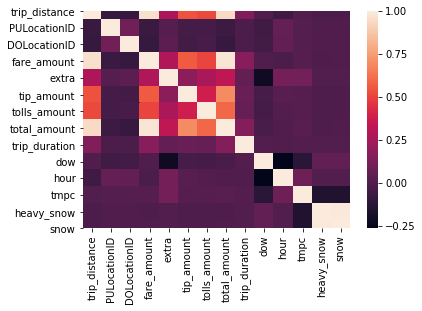

In [13]:
sns.heatmap(df1.corr())

- Obviously, snow and heavy_snow will have almost a correlation of 1, as snow is a subset of heavy_snow
- We also observe that the fare_amount, total_amount and trip_distance all share a strong positive correlation
    - Since we want to work with the bare minimum profit, we should not use total_amount since it incooporates several other factors which cannot be accounted for (variable rates)
- Tip amounts also shares a strong positive correlation with the fare_amount (by default it is 15%), but must be conditioned on the assumption that the trip was payed in card, since tips for trips paid in cash will not be recorded
- trip_duration does not seem to have any correlation with any other attributes, but in reality we know a longer trip should have more fare_amount

# A way of measuring profit conditioned on the assumptions
- **We want to see if the the profitability of zones remains consistent with respect to hour of day, day of week and pickup location. The distribution of profitable zones should be similar across all years**.

- Although it is conditioned on months that had snow fall, we partition this into days with snow, and days without snow
    - This is because there are more trips conducted during snow conditions, but at a much shorter duration (refer A1)

`[(fare_amount / trip_duration) + toll + extra] * (freq_zone / total number of trips)`

In [14]:
df1.head()

,trip_distance,PULocationID,DOLocationID,fare_amount,extra,tip_amount,tolls_amount,total_amount,trip_duration,dow,hour,tmpc,heavy_snow,snow
0,0.5000,48,48,4.0000,0.5000,0.0000,0.0000,5.3000,3,6,0,7.0000,0.0000,0.0000
1,7.7500,186,36,22.0000,0.5000,4.6600,0.0000,27.9600,39,6,0,7.0000,0.0000,0.0000
2,0.8000,162,161,6.0000,0.5000,1.4500,0.0000,8.7500,6,6,0,7.0000,0.0000,0.0000
3,0.9000,48,50,7.0000,0.5000,0.0000,0.0000,8.3000,8,6,0,7.0000,0.0000,0.0000
4,1.7600,140,74,7.0000,0.5000,0.0000,0.0000,8.3000,4,6,0,7.0000,0.0000,0.0000


In [45]:
proportion_freq = df1.groupby(['dow','hour','PULocationID'])['trip_distance'].count() / df1.groupby(['dow','hour'])['trip_distance'].count().median()

proportion_freq = proportion_freq.reset_index().rename({'trip_distance': 'freq_prop'}, axis=1)
most_common = df1.groupby(['dow','hour','PULocationID'])[['extra','tolls_amount']].agg(pd.Series.mode).reset_index()

to_merge = pd.merge(proportion_freq, most_common, on=['dow','hour','PULocationID']).rename({'extra': 'common_extra',
                                                                                           'tolls_amount': 'common_toll'}, axis=1)

df1 = pd.merge(df1, to_merge, on=['dow','hour','PULocationID'])

In [16]:
df1.head()

,trip_distance,PULocationID,DOLocationID,fare_amount,extra,tip_amount,tolls_amount,total_amount,trip_duration,dow,hour,tmpc,heavy_snow,snow,freq_prop,common_extra,common_toll
0,0.5000,48,48,4.0000,0.5000,0.0000,0.0000,5.3000,3,6,0,7.0000,0.0000,0.0000,0.4193,0.5000,0.0000
1,0.9000,48,50,7.0000,0.5000,0.0000,0.0000,8.3000,8,6,0,7.0000,0.0000,0.0000,0.4193,0.5000,0.0000
2,0.6500,48,68,6.5000,0.5000,1.7000,0.0000,9.5000,7,6,0,7.0000,0.0000,0.0000,0.4193,0.5000,0.0000
3,7.3000,48,48,22.5000,0.5000,0.0000,0.0000,23.8000,17,6,0,7.0000,0.0000,0.0000,0.4193,0.5000,0.0000
4,1.2200,48,143,7.0000,0.5000,1.6600,0.0000,9.9600,8,6,0,7.0000,0.0000,0.0000,0.4193,0.5000,0.0000


In [17]:
df1.dtypes

trip_distance    float64
PULocationID       int64
DOLocationID       int64
fare_amount      float64
extra            float64
tip_amount       float64
tolls_amount     float64
total_amount     float64
trip_duration      int64
dow                int64
hour               int64
tmpc             float64
heavy_snow       float64
snow             float64
freq_prop        float64
common_extra      object
common_toll       object
dtype: object

In [46]:
df1['common_toll'] = df1['common_toll'].apply(lambda x: float(x) if type(x) == np.float64 else float(x[0]))
df1['common_extra'] = df1['common_extra'].apply(lambda x: float(x) if type(x) == np.float64 else float(x[0]))

In [47]:
df1['rating'] = (0.5 * ((df1['fare_amount'] / df1['trip_duration']) + 
                        (df1['fare_amount'] / df1['trip_distance'])) + 
                 df1['common_extra'] + df1['common_toll']) * df1['freq_prop']

In [48]:
df1['rating'].describe()

count        23,820,598.0000
mean                  1.0202
std                   1.5858
min                   0.0000
25%                   0.3853
50%                   0.8294
75%                   1.4280
max               1,343.4289
Name: rating, dtype: float64

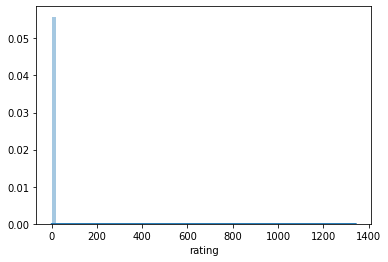

In [49]:
sns.distplot(df1['rating'], bins=75)

Hmm this distribution doesn't look too good to work with

In [50]:
np.log(df1['rating']).describe()

count        23,820,598.0000
mean                 -0.4553
std                   1.2251
min                 -10.0307
25%                  -0.9537
50%                  -0.1870
75%                   0.3563
max                   7.2030
Name: rating, dtype: float64

In [65]:
from scipy import stats

In [ ]:
sns.distplot(np.log(df1['rating']), bins=50)

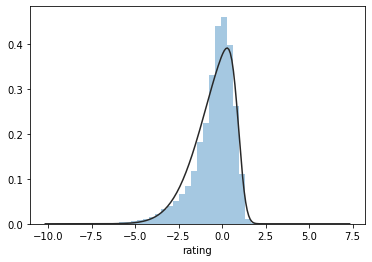

In [68]:
sns.distplot(np.log(df1['rating']), kde=False, fit=stats.skewnorm)

This one looks significantly better even if it's negative skewed. We will decide to work with the log distribution and scale to have mean 0 in order to make the distribution closer to a Guassian.

In [ ]:
sns.distplot(np.log(df1['rating'])

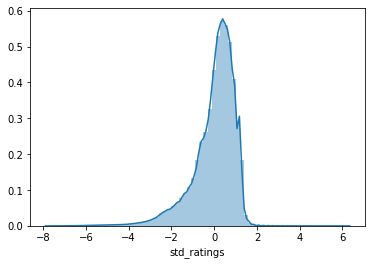

In [52]:
df1['std_ratings'] = stats.zscore(np.log(df1['rating']))
sns.distplot(df1['std_ratings'], bins=75)

In [53]:
df1['std_ratings'].describe()

count        23,820,598.0000
mean                  0.0000
std                   1.0000
min                  -7.8161
25%                  -0.4068
50%                   0.2190
75%                   0.6624
max                   6.2512
Name: std_ratings, dtype: float64

In [54]:
labels = pd.qcut(df1['std_ratings'], q=5)
df1['label'] = labels.cat.codes

In [27]:
labels.cat.categories

IntervalIndex([(-8.383, -0.602], (-0.602, 0.0417], (0.0417, 0.394], (0.394, 0.75], (0.75, 6.585]],
              closed='right',
              dtype='interval[float64]')

In [55]:
# 2018
labels.cat.categories

IntervalIndex([(-7.817, -0.611], (-0.611, 0.0248], (0.0248, 0.396], (0.396, 0.759], (0.759, 6.251]],
              closed='right',
              dtype='interval[float64]')

In [56]:
train = df1[['PULocationID','dow','hour','tmpc','heavy_snow','snow', 'label']].fillna(0)

In [29]:
train.corr()

,PULocationID,dow,hour,tmpc,heavy_snow,snow,label
PULocationID,1.0000,-0.0502,0.0634,0.0140,0.0010,0.0011,0.1265
dow,-0.0502,1.0000,-0.2644,-0.1298,0.0522,0.0513,-0.0331
hour,0.0634,-0.2644,1.0000,0.0890,0.0055,0.0039,0.2822
tmpc,0.0140,-0.1298,0.0890,1.0000,-0.1533,-0.1526,0.0466
heavy_snow,0.0010,0.0522,0.0055,-0.1533,1.0000,0.9912,-0.0059
snow,0.0011,0.0513,0.0039,-0.1526,0.9912,1.0000,-0.0060
label,0.1265,-0.0331,0.2822,0.0466,-0.0059,-0.0060,1.0000


In [57]:
train.to_feather('./ml_data/2018dev.feather')

In [31]:
cols = ['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
        'PULocationID', 'DOLocationID', 'payment_type',
       'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'total_amount', 'trip_duration', 'dow', 'hour', 'tmpc', 'heavy_snow',
       'snow', 'freq_prop', 'common_extra', 'common_toll', 'rating']

In [32]:
from sklearn.feature_selection import mutual_info_regression as MI

In [33]:
t = train.sample(100000)

In [34]:
mi = MI(t[['PULocationID','dow','hour','tmpc','heavy_snow','snow']], t['label'])

In [35]:
mi

array([0.40277318, 0.0134122 , 0.12402128, 0.01055888, 0.00142246,
       0.00333726])

In [36]:
results = pd.DataFrame(mi).T
results.columns = ['PULocationID','dow','hour','tmpc','heavy_snow','snow']
results

,PULocationID,dow,hour,tmpc,heavy_snow,snow
0,0.4028,0.0134,0.1240,0.0106,0.0014,0.0033


- Since mutual information is an expensive calculation, we can take a sample size of 1 million from the train data to roughly see the mutual information with respect to the label.
- We also take a smaller sample of 100,000 from the original data to see which attributes have a high mutual information. We expect `fare_amount`, `trip_duration`, `extra`, `tolls_amount` to have a high MI

In [37]:
cols = ['trip_distance', 'PULocationID', 'DOLocationID','fare_amount', 'extra','tip_amount', 'tolls_amount','trip_duration', 'dow', 'hour', 'tmpc', 'heavy_snow', 'snow']
d = df1.sample(100000).fillna(0)

In [38]:
mi2 = MI(d[cols], d['label'])

In [39]:
mi2

array([0.05883667, 0.39934104, 0.07287775, 0.0260013 , 0.03441997,
       0.01653964, 0.00513405, 0.00828623, 0.01492824, 0.1239243 ,
       0.01166777, 0.00224454, 0.00232358])

In [40]:
results2 = pd.DataFrame(mi2).T
results2.columns = cols
results2

,trip_distance,PULocationID,DOLocationID,fare_amount,extra,tip_amount,tolls_amount,trip_duration,dow,hour,tmpc,heavy_snow,snow
0,0.0588,0.3993,0.0729,0.0260,0.0344,0.0165,0.0051,0.0083,0.0149,0.1239,0.0117,0.0022,0.0023


Interesting... We observe similar traits with the "realistic" attributes - where `PULocationID` and `hour` alone share high mutual information with the label. Even though the label is dependent on the posterior attributes, it seems that there is no likely relationship.
- Perhaps these two attributes are enough to predict if a zone is profitable

# Playground - Random Experiments
- Yeh look, trying to predict `fare_amount` shows Zero-R like performance

X = df1[['PULocationID', 'dow', 'hour', 'tmpc','heavy_snow']].fillna(0)
y = pd.qcut(df1.fare_amount, q=5, labels=False)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

cross_val_score(LogisticRegression(), X, y, cv=3)

cross_val_score(DecisionTreeClassifier(max_depth=None), X, y, cv=3)

bins = pd.IntervalIndex.from_tuples([(0, 5), (5, 10), (10, 15), (15, 30), (30, 50), (50, 75), (75, 100), (100, 150), (150, 100000)])
labels = pd.cut(df1.fare_amount, bins, labels=False)
y = labels.cat.codes

labels.value_counts()

pd.qcut(df1.fare_amount, 20)

y.value_counts()

df1['label']